# Домашнее задание. Решение конкурса на kaggle.com

Это домашнее задание посвящено полноценному решению задачи машинного обучения.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить, используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
submission=True
sns.set_theme()

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки.

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [4]:
data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

In [5]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
# Проверяю кол-во яйчеек с NaN
data_train.isna().sum()


ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [7]:
# Общая информация по DataFrame
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [8]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [9]:
# Формат стобца total должен быть представлен как float64.
# Столбец включает 9 пропусков
data_train['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

In [10]:
#Все клиенты с TatolSpent равным пропуском провели на сайте 0 часов, поэтому должно быть и потратили там 0 едениц.
data_train[data_train['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [11]:
#Заменяем пропуски на ноль
data_train.loc[(data_train['TotalSpent'] == " "), 'TotalSpent'] = "0.0"
data_train['TotalSpent'] = data_train['TotalSpent'].astype(float)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [12]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [13]:
# тоже самое проводим для тестовой выборки
data_test.loc[(data_test['TotalSpent'] == " "), 'TotalSpent'] = "0.0"
data_test['TotalSpent'] = data_test['TotalSpent'].astype(float)

## Анализ данных (3 балла)



(array([1394.,  636.,  503.,  397.,  280.,  233.,  201.,  188.,  175.,
         172.,  151.,  160.,  151.,  153.,  120.,  103.,   91.,   82.,
          61.,   31.]),
 array([   0.  ,  434.24,  868.48, 1302.72, 1736.96, 2171.2 , 2605.44,
        3039.68, 3473.92, 3908.16, 4342.4 , 4776.64, 5210.88, 5645.12,
        6079.36, 6513.6 , 6947.84, 7382.08, 7816.32, 8250.56, 8684.8 ]),
 <BarContainer object of 20 artists>)

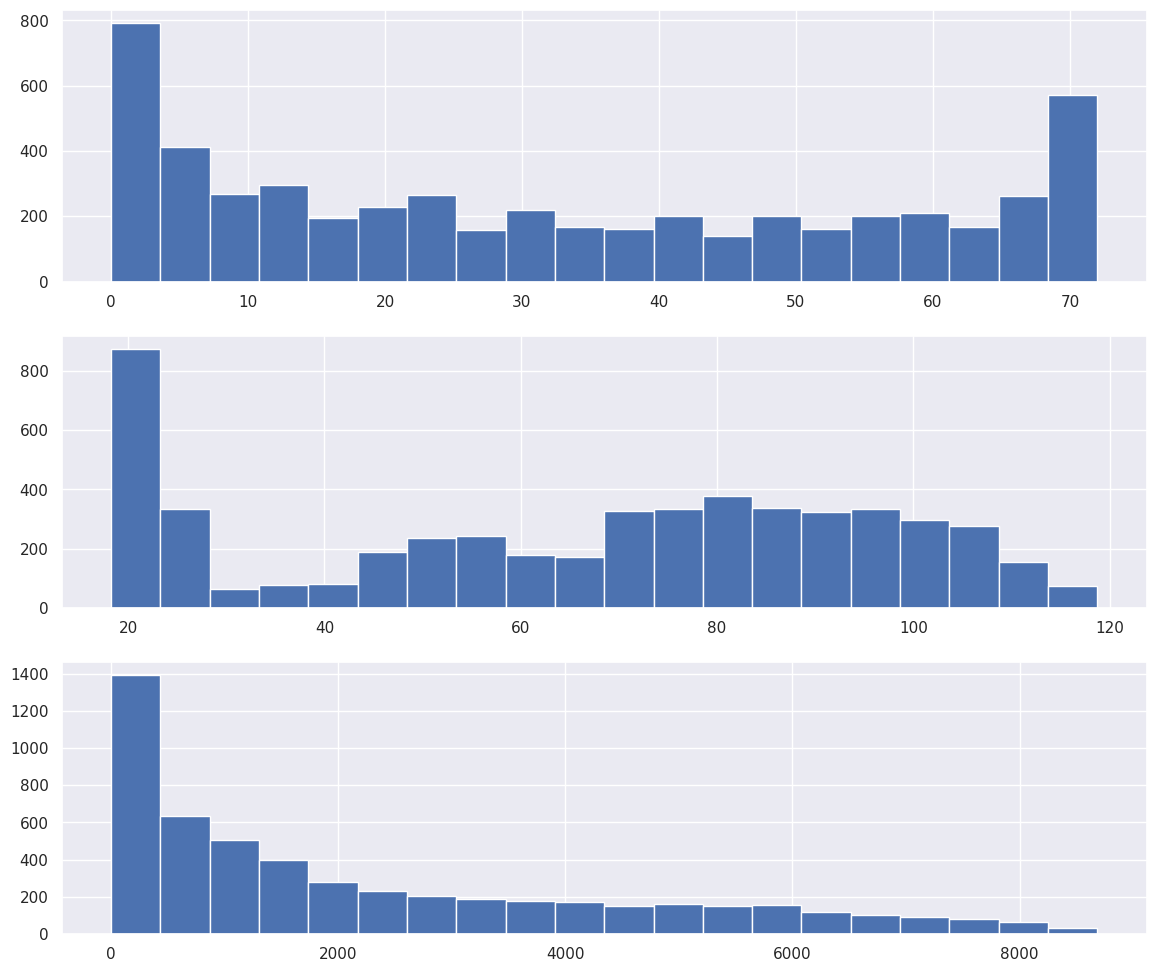

In [18]:
#Численные признаки
fig,ax = plt.subplots(3,1,figsize = (14,12))
ax[0].hist(data_train['ClientPeriod'], bins = 20)
ax[1].hist(data_train['MonthlySpending'], bins = 20)
ax[2].hist(data_train['TotalSpent'], bins = 20)

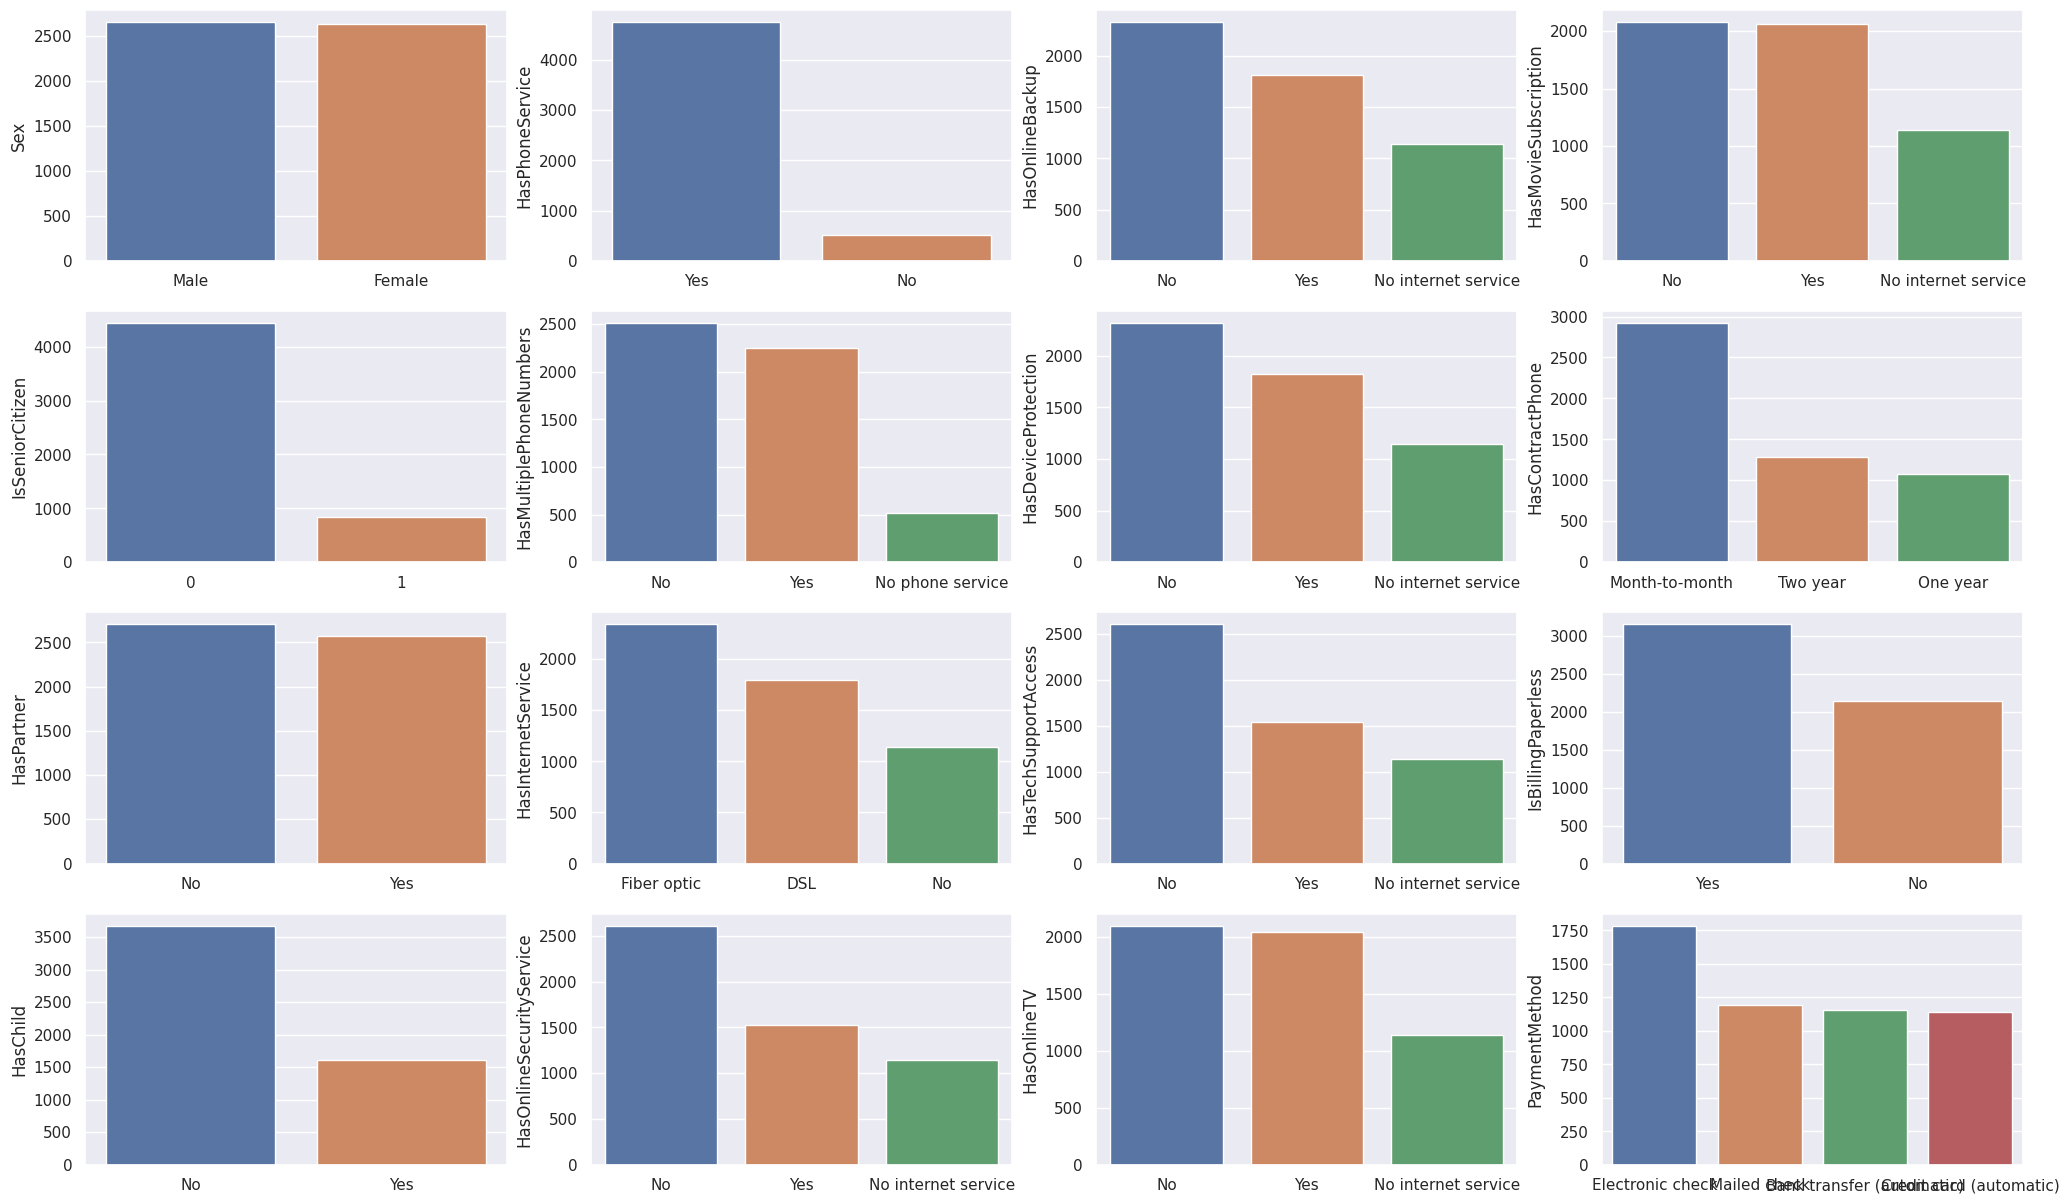

In [19]:
#Категориальные признаки
fig, axs = plt.subplots(4, 4, figsize = (25, 15))
for ind, name in enumerate(cat_cols):
    aa = data_train[name].value_counts()
    sns.barplot(x = aa.index, y = aa, ax = axs[ind - 4 * (ind // 4), ind // 4])

Text(0.5, 1.0, 'Распределение целевой переменной')

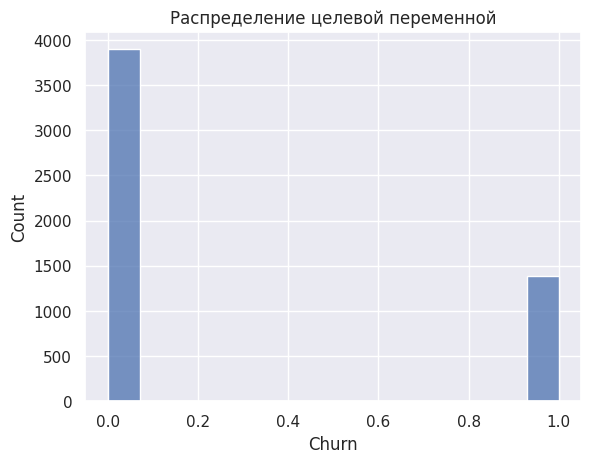

In [20]:
#Классы несбалансированы
ax = sns.histplot(data=data_train, x="Churn")
ax.set_title("Распределение целевой переменной")

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [23]:
std_scaler = StandardScaler()
log_reg = LogisticRegressionCV(scoring='roc_auc')

In [24]:
#нормирование числовых признаков и кодирование категориальных через one-hot encoding
# разделение данных на тестовую и тестируемую выборку
std_num = std_scaler.fit_transform(data_train[num_cols])
dum_cat = pd.get_dummies(data_train[cat_cols])
X = pd.DataFrame(std_num, columns=num_cols).join(dum_cat)
y = data_train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [25]:
#Обучение модели через логистическую регрессию и подбор гиперпараметров
cv = GridSearchCV(estimator = log_reg,
                  param_grid={
                      'penalty': ['l1', 'l2'],
                      'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
                  },
                  scoring='roc_auc',
                  n_jobs=-1,
                  verbose=0
)
cv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

GridSearchCV(estimator=LogisticRegressionCV(scoring='roc_auc'), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [26]:
print(cv.score(X_train, y_train), cv.score(X_test, y_test))

0.853840313727855 0.8268209565851812


In [27]:
cv.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [28]:
!pip3 install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.4 MB/s eta 0:00:00


Применение градиентного бустинга (2 балла)

In [29]:
from catboost import CatBoostClassifier

In [30]:
catb_class = CatBoostClassifier(logging_level='Silent')

In [31]:
#Деление выборки на тренировочную и тестовую
X = data_train.drop(target_col, axis=1)
y = data_train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [32]:
#Обучение
catb_class.fit(X_train, y_train, cat_features=cat_cols)

In [33]:
#метрика
roc_auc_score(y_test, catb_class.predict_proba(X_test)[:, 1])

0.823387759625419

In [34]:
#Обучение и гиперпараметры
parameters = {
    'iterations':[100, 300, 500, 700],
    'depth':[3, 5, 6, 7],
}

cv = GridSearchCV(catb_class, param_grid=parameters, n_jobs=-1)
cv.fit(X_train, y_train, cat_features=cat_cols)

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7be988d2cf70>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 6, 7],
                         'iterations': [100, 300, 500, 700]})

In [35]:
cv.best_params_

{'depth': 3, 'iterations': 700}

In [36]:
roc_auc_score(y_test, cv.predict_proba(X_test)[:, 1])

0.8302287566609101

# Предсказания

In [37]:
best_model = CatBoostClassifier(iterations=700, depth=3, logging_level='Silent')

In [38]:
best_model.fit(X_train, y_train, cat_features=cat_cols)

In [39]:
submission['Churn'] = best_model.predict_proba(data_test)[:, 1]
submission.to_csv('./submission.csv', index=False)